In [1]:
using ForwardDiff
using Plots
using SimpleSolvers

using ForwardDiff

using LinearAlgebra
using LogExpFunctions, Distances
using WassersteinDictionaries

using Optim, LineSearches
using LinearMaps, IterativeSolvers

In [2]:
### Operators

@inline function inc(i,n)
    i + 1 > n ? i : i + 1
end

@inline function dec(i,n)
    i - 1 < 1 ? i : i - 1
end

function _apply_R!(y::AbstractVector, x::AbstractVector, ci, li, h₁, h₂) # Nullspace projection
    n₁, n₂ = size(ci)
    length(x) == length(y) || throw(DimensionMismatch())
    Σx = sum(x) * h₁ * h₂
    @inbounds for ij in li
        y[ij] = Σx
    end
end

function _apply_Δ₂!(y::AbstractVector, x::AbstractVector, ci, li, h₁, h₂) # 2D Laplace operator
    n₁, n₂ = size(ci)
    length(x) == length(y) || throw(DimensionMismatch())

    @inbounds for ij in li
        i,j = Tuple(ci[ij])
        y[ij] = ( x[ li[inc(i,n₁), j] ] / (h₁^2)
                - 2*x[ij] / (h₁^2)
                + x[ li[dec(i,n₁), j] ] / (h₁^2)
                + x[ li[i,inc(j,n₂)] ] / (h₂^2)
                - 2*x[ij] / (h₂^2)
                + x[ li[i,dec(j,n₂)] ] / (h₂^2)
            )
    end
end

function _apply_∂x₂!(y::AbstractVector, x::AbstractVector, ci, li, h₁, h₂)
    n₁, n₂ = size(ci)
    length(x) == length(y) || throw(DimensionMismatch())
    for ij in li
        i,j = Tuple(ci[ij])
        y[ij] = 1 / (2h₁) * ( - x[ li[dec(i,n₁),j] ] + x[ li[inc(i,n₁),j] ] )
    end
end

function _apply_∂y₂!(y::AbstractVector, x::AbstractVector, ci, li, h₁, h₂)
    n₁, n₂ = size(ci)
    length(x) == length(y) || throw(DimensionMismatch())
    for ij in li
        i,j = Tuple(ci[ij])
        y[ij] = 1 / (2h₂) * ( - x[ li[ i ,dec(j,n₂)] ] + x[ li[ i ,inc(j,n₂)] ] )
    end
end

_apply_∂y₂! (generic function with 1 method)

In [3]:
const d = 2
const N = 200
const N₁ = N
const N₂ = N

x₁ = collect(range(0,1,length=N₁))
x₂ = collect(range(0,1,length=N₂));

h₁ = 1/N₁
h₂ = 1/N₂

ci = CartesianIndices(x₁*x₂')
li = LinearIndices(x₁*x₂');

In [4]:
function _closure_apply_R!(y::AbstractVector, x::AbstractVector)
    _apply_R!(y::AbstractVector, x::AbstractVector, ci, li, h₁, h₂)
end

R = LinearMap(_closure_apply_R!, _closure_apply_R!, N₁*N₂; ismutating=true, issymmetric=true)

function _closure_apply_Δ₂!(y::AbstractVector, x::AbstractVector)
    _apply_Δ₂!(y::AbstractVector, x::AbstractVector, ci, li, h₁, h₂)
end

Δ₂ = LinearMap(_closure_apply_Δ₂!, _closure_apply_Δ₂!, N₁*N₂ ;ismutating=true, issymmetric=true)

function _closure_apply_∂x₂!(y::AbstractVector, x::AbstractVector)
    _apply_∂x₂!(y::AbstractVector, x::AbstractVector, ci, li, h₁, h₂)
end

function _closure_apply_∂y₂!(y::AbstractVector, x::AbstractVector)
    _apply_∂y₂!(y::AbstractVector, x::AbstractVector, ci, li, h₁, h₂)
end

∂x₂ = LinearMap(_closure_apply_∂x₂!,
                    _closure_apply_∂x₂!,
                    N₁*N₂;  
                    ismutating=true, issymmetric=false)

∂y₂ = LinearMap(_closure_apply_∂y₂!,
                _closure_apply_∂y₂!,
                N₁*N₂;
                    ismutating=true, issymmetric=false)

function _do_nothing!(y::AbstractVector, x::AbstractVector)
    y .= x
end

Id = LinearMap(_do_nothing!, _do_nothing!, N₁*N₂; ismutating=true, issymmetric=false);

In [5]:
c = WassersteinDictionaries.get_cost_matrix_separated(N, d);

In [6]:

#f₀_m = [ exp( -((_x-0.25)^2 + (_y-0.25)^2) / 0.0025 ) for _x in x₁, _y in x₂ ]; # burgers
f₀_m = [ exp( -((_x-0.2)^2 + (_y-0.2)^2) / 0.0025 ) for _x in x₁, _y in x₂ ] # + [ exp( -((_x-0.6)^2 + (_y-0.3)^2) / 0.002 ) for _x in x₁, _y in x₂ ]; # circular flow
#f₀_m = [ norm( [_x _y]-[0.2 0.2], Inf) < 0.1 ? 1.0 : 0.0 for _x in x, _y in y ];
#f₀_m = [ exp( -((_x-0.5)^2 + (_y-0.5)^2) / 0.0025 ) for _x in x₁, _y in x₂ ]  # pure diffusion

f₀_m ./= (sum(f₀_m)*h₁*h₂);
f₀ = vec(f₀_m);

In [7]:
nₜ = 1000

μ = range(0, 0.01, length = 5)
θ = π/4 # range(0,π/2,length=5)
a = 0 # 2.5

F = zeros(N₁*N₂, (nₜ) * length( μ ) * length( θ ) * length(a)  )

params = zeros(4, (nₜ+1) * length( μ ) * length( θ ) * length(a)  ) # t, μ, θ, a


a₁ = (vec([ _y-0.5 for _x in x₁ , _y in x₂ ]))
a₂ = (vec([ -_x+0.5 for _x in x₁, _y in x₂ ]))

Δt = 1/nₜ
ν = 2e-3
L_B = Id - ν*Δt*Δ₂

i = 1

f = copy(f₀)
rhs = copy(f₀)

p = []

for _μ in μ
    for _θ in θ
        for _a in a
            f .= f₀

            for _t in 1:(nₜ)
                rhs .= f
                rhs .= f .- Δt .* 0.66 .* ( 1 .+ _μ .* f ) .* ( cos(_θ) * ∂x₂ * f + sin(_θ) * ∂y₂ * f )  # Burgers: ∂ₜf + (1 + μ f) a ⋅ ∇f = ν Δf
                #rhs .= f .- Δt .* ( 1 .+ _μ .* f ) .* ( _a .* a₁ .* (∂x₂ * f) .+ _a .* a₂ .* (∂y₂ * f) )
                cg!(f, L_B, rhs)

                F[:,i] .= f

                if _t == 1 || _t % 20 == 0
                    push!(p, reshape(abs.(F[:,i]),N₁,N₂))
                end

                i += 1
            end
        end
    end
end

In [8]:
nₚ_full = (nₜ) * length( μ ) * length( θ ) * length(a)

5000

In [9]:
#p = [ reshape(abs.(F[:,i]),n,n) for i in vcat(collect(1:23:nₚ_full),nₚ_full) ]
#paramsₛ = [ params[:,i] for i in vcat(collect(1:23:nₚ_full),nₚ_full) ]

c_max = maximum(maximum.(p));
nₚ = length(p)

255

In [10]:
nₚ / length(μ)

51.0

In [43]:
plt = contour(x₁, x₂, p[1], clim = (0,c_max), c=:viridis)
#for i in 1:5
#    contour!(x₁, x₂, p[i*51], clim = (0,c_max), c=:viridis, grid=false)
#    contour!(x₁, x₂, p[i*51 - 25], clim = (0,c_max), c=:viridis, grid=false)
#end
contour!(x₁, x₂, p[end-25], clim = (0,c_max), c=:viridis)
contour!(x₁, x₂, p[end], clim = (0,c_max), c=:viridis)
plt
#savefig("snaps.pdf")

In [12]:
ε = 2e-3

SP = SinkhornParameters(32, ε)
SPB = SinkhornParameters(512, ε)

k = WassersteinDictionaries.get_gibbs_matrix( c, ε)

α_indices = vcat(1,collect(2:1:nₚ))
α = [ p[s] for s in α_indices ]

for s in eachindex(α)
    α[s] ./= (sum(α[s])*h₁*h₂);
end

log_α = [ log.(α[s]) for s in α_indices ]
nₛ = length(α)

a₀ = ones(size(α[1])); b₀ = ones(size(α[1]))
d₀₁ = ones(size(α[1])); d₀₂ = ones(size(α[1]))

x_trace = []
y_trace = [];

In [14]:
nₛ, (nₛ-1)/2

(255, 127.0)

In [15]:
### Reference = Barycenter
β_indices = 1:5:nₛ
nβₛ = length(β_indices)

51

In [16]:
### Reference = Barycenter

a_₀ = [ones(size(α[s])) for s in β_indices] 
d₀ = ones(size(α[1]));

caches = ( MC = MatrixCache(nβₛ,N), VMC = VectorMatrixCache(nβₛ,N), VC = VectorCache(nβₛ,N) )

SPB.L = 256
SPB.tol = 1e-6 * h₁ * h₂

SPB.debias = false
SPB.averaged_updates = false
SPB.update_potentials = true
β = sinkhorn_barycenter_sep([ 1/nβₛ for _ in 1:nβₛ ], α[β_indices], a_₀, d₀, k, SPB, caches);

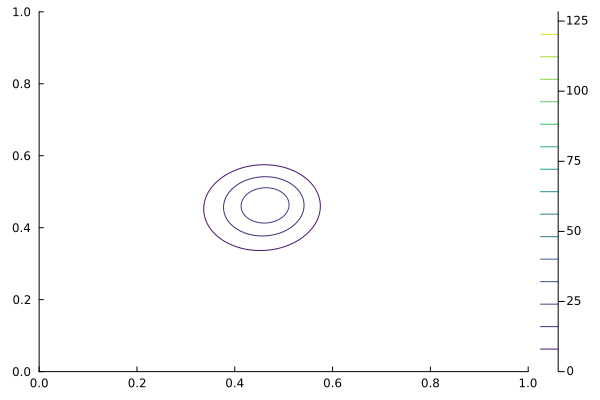

In [17]:
contour(x₁, x₂, β, clim = (0,c_max), c=:viridis, grid=false)
#contour!(x₁, x₂, p[end], clim = (0,c_max), c=:viridis, grid=false)
#contour!(x₁, x₂, p[end-25], clim = (0,c_max), c=:viridis, grid=false)
#contour!(x₁, x₂, p[end-50], clim = (0,c_max), c=:viridis, grid=false)
#savefig("ex2sigma.pdf")

In [19]:
## If σ is given: need to compute transport potentials from α[s] to σ
ψ  = [ones(size(α[s])) for s in eachindex(α)] # ψ = f
ψᶜ = [ones(size(α[s])) for s in eachindex(α)];

a₀ = ones(size(α[1])); b₀ = ones(size(α[1]))
d₀₁ = ones(size(α[1])); d₀₂ = ones(size(α[1]))

SP.L = 128
SP.tol = 1e-6 * h₁ * h₂

SP.debias = false
SP.averaged_updates = false
SP.update_potentials = true

for s in eachindex(α)

    a₀ .= 1.0
    b₀ .= 1.0

    #ψ[s] .= log.(a_₀[s]) * ε # if barycenter was computed from all snaps

    sinkhorn_dvg_sep( α[s], β, a₀, b₀, d₀₁, d₀₂, k, SP, caches)
    ψ[s] .= log.(a₀) * ε

    WassersteinDictionaries.softmin_separated!(ψᶜ[s], ψ[s], log.(α[s]), 1e-9, c, caches.VC[:t1,Float64], caches.MC[:t2,Float64])
end

In [20]:
# a[s] is the potential from α[s] to σ aka T aka ψ
#=
for s in eachindex(α)
    ψ[s] .= log.(a_₀[s]) * ε
    WassersteinDictionaries.softmin_separated!(ψᶜ[s], ψ[s], log.(α[s]), 1e-6, 0.5*c, caches.VC[:t1,Float64], caches.MC[:t2,Float64])
    #WassersteinDictionaries.softmin_separated!(ψᶜ[s], ψ[s], log_β, 1e-6, 0.5*c, caches.VC[:t1,Float64], caches.MC[:t2,Float64])
    

    #ψ[s] .*= -1
    #softmin_separated!(ψᶜ[s], -ψ[s], log_α[s], 1e-6, 0.5*c, caches.VC[:t1,Float64], caches.MC[:t2,Float64])
    #ψᶜ[s] .*= -1
end
=#

In [21]:
# ψ  = -f
# ψᶜ = -g

# a = α exp(-ψ/ε)   
# b = β exp(-ψᶜ/ε)

#=

ψ  = [ones(size(α[s])) for s in eachindex(α)]
ψᶜ = [ones(size(α[s])) for s in eachindex(α)]

dₛ = ones(size(α[1]))

for s in eachindex(b_₀)
    WassersteinDictionaries.apply_K_sep!(caches.MC[:t2,Float64], b_₀[s] , k, caches.MC[:t1,Float64])
    caches.MC[:a_α,Float64] .= 1 ./ caches.MC[:t2,Float64]

    for _ in 1:5
        WassersteinDictionaries.apply_K_sep!(caches.MC[:t2,Float64], dₛ , k, caches.MC[:t1,Float64]) # t2 = Kd
        dₛ .= sqrt.( dₛ .* abs.(α[s]) ./ caches.MC[:t2,Float64] )
    end

    ψ[s] .= - ε * ( log.( caches.MC[:a_α,Float64] ) )#  - log.( dₛ ) )


    caches.MC[:a,Float64] .= caches.MC[:a_α,Float64] .* α[s]

    WassersteinDictionaries.apply_K_sep!(caches.MC[:t2,Float64], caches.MC[:a,Float64], k, caches.MC[:t1,Float64])
    caches.MC[:b_β,Float64] .= 1 ./ caches.MC[:t2,Float64]

    ψᶜ[s] .= - ε * ( log.( caches.MC[:b_β,Float64] ) )#  - log.( d₀ ) )
end
=#


In [22]:
x² = [ x^2 + y^2 for x in x₁, y in x₂ ];

In [23]:
#ψ  = [ - ε * log.(a_₀[s]) for s in eachindex(α) ];
#ψᶜ = [ - ε * log.(b_₀[s]) for s in eachindex(α) ];

In [24]:
φᶜ = [ 0.5x² + ψᶜ[s] for s in eachindex(α) ];

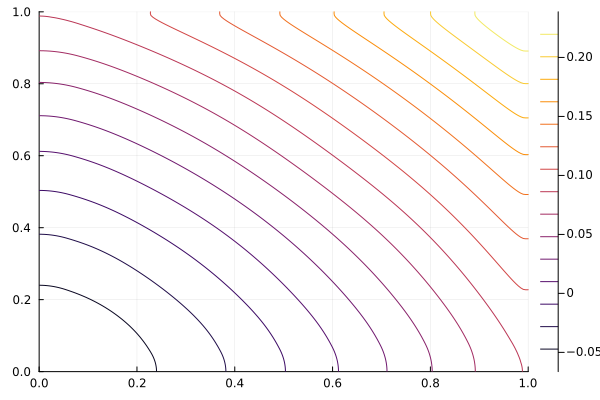

In [25]:
_s = 10
contour(x₁, x₂, ψᶜ[_s])
#contour!(x₁, x₂, 0.01*β)
#contour!(x₁, x₂, 0.01*α[_s])

In [26]:
function __eval(f::AbstractVector{T},i,j,ci,li) where T
    n₁, n₂ = size(ci)
    if i < 1 || j < 1 || i > n₁ || j > n₂
        return zero(T)
    else
        return f[ li[ i,j ] ]
    end
end

__eval (generic function with 1 method)

In [27]:
function _apply_∇σ∇!(y::AbstractVector, x::AbstractVector, σ::AbstractVector, ci, li, h₁, h₂) # 2D Laplace operator
    n₁, n₂ = size(ci)
    length(x) == length(y) == length(σ) || throw(DimensionMismatch())

    _eval(x,i,j) = __eval(x,i,j,ci,li) 

    @inbounds for ij in li
        i,j = Tuple(ci[ij])

        ∂xx = ( (_eval(x,i+1,j) - x[ij])*(_eval(σ,i+1,j) + σ[ij])
                + (_eval(x,i-1,j) - x[ij])*(_eval(σ,i-1,j) + σ[ij]) ) / 2 / h₁ / h₁ 

        ∂yy = ( (_eval(x,i,j+1) - x[ij])*(_eval(σ,i,j+1) + σ[ij])
                + (_eval(x,i,j-1) - x[ij])*(_eval(σ,i,j-1) + σ[ij]) ) / 2 / h₂ / h₂ 


        y[ij] = ∂xx + ∂yy
    end
end

_closure_apply_∇σ∇!(y,x) = _apply_∇σ∇!(y,x,vec(β),ci,li,h₁,h₂) 

∇σ∇ = LinearMap(_closure_apply_∇σ∇!, N₁*N₂; issymmetric=true, ismutating=true )

40000×40000 LinearMaps.FunctionMap{Float64}(_closure_apply_∇σ∇!; ismutating=true, issymmetric=true, ishermitian=true, isposdef=false)

In [28]:
Φᶜ = zeros(N₁*N₂,nₛ)
Ψᶜ = zeros(N₁*N₂,nₛ)
S = zeros(N₁*N₂,nₛ)
for s in 1:nₛ
    Φᶜ[:,s] = vec(φᶜ[s])
    Ψᶜ[:,s] = vec(ψᶜ[s])
    S[:,s] = vec(α[s])
end

In [29]:
KΨᶜ = - h₁ * h₂ * Matrix(Ψᶜ' * ∇σ∇ * Ψᶜ) ;
KΦᶜ = - h₁ * h₂ * Matrix(Φᶜ' * ∇σ∇ * Φᶜ) ;

In [30]:
evdS = eigen(S' * S * h₁ * h₂, sortby = x -> -abs(x) )
evdΦᶜ = eigen(0.5 * (KΦᶜ' + KΦᶜ), sortby = x -> -abs(x) );
evdΨᶜ = eigen(0.5 * (KΨᶜ' + KΨᶜ) , sortby = x -> -abs(x) );

In [31]:
ΛS = abs.(evdS.values);
ΛΦᶜ = abs.(evdΦᶜ.values);
ΛΨᶜ = abs.(evdΨᶜ.values);
ΛΨᶜ[1:5]' ./ ΛΨᶜ[1]

1×5 Matrix{Float64}:
 1.0  0.000470615  3.8649e-5  1.71057e-5  5.42624e-6

In [32]:
#ΛS_diffusion = copy(ΛS);

In [33]:
#plot(ΛS[1:15] ./ ΛS[1],  yaxis=:log, linewidth=2, ylim=(1e-17,1e1), marker = :square, xlabel = "n", ylabel = "λₙ / λ₁", yticks = [1, 1e-5, 1e-10, 1e-15],
#c=pal[1], legend = :bottomleft, label = "∂ₜf + a⋅∇f = νΔf", xlim = (0,16), minorgrid = false, legendfontsize=10, tickfontsize = 10)
#plot!(ΛS_diffusion[1:15] ./ ΛS_diffusion[1], linewidth=2, c=pal[3], marker = :square, label = "∂ₜf = νΔf" )
#savefig("advection-diffusion.pdf")


In [34]:
UΦᶜ = Φᶜ * evdΦᶜ.vectors * diagm(1 ./ sqrt.(abs.(ΛΦᶜ)) )
US = S * evdS.vectors * diagm(1 ./ sqrt.(abs.(ΛS)) )
UΨᶜ = Ψᶜ * evdΨᶜ.vectors * diagm(1 ./ sqrt.(abs.(ΛΨᶜ)) )
EΦᶜ = [ sum(ΛΦᶜ[1:k]) / sum(ΛΦᶜ) for k in 1:length(ΛΦᶜ)]
ES = [ sum(ΛS[1:k]) / sum(ΛS) for k in 1:length(ΛS)];
EΨᶜ = [ sum(ΛΨᶜ[1:k]) / sum(ΛΨᶜ) for k in 1:length(ΛΨᶜ)];

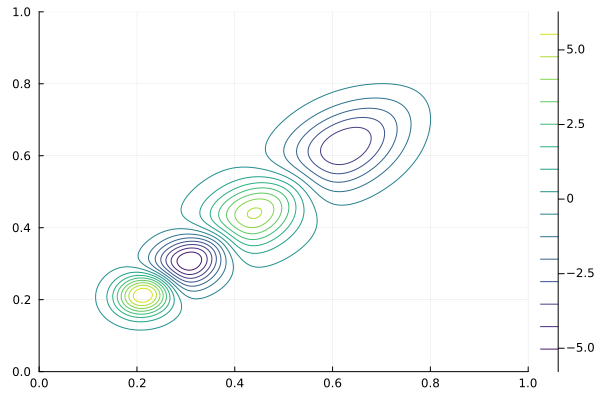

In [40]:
contour(x₁, x₂, US[:,4], c = :viridis)
#savefig("globmode4.pdf")

In [106]:
pal = cgrad(:viridis, 5, categorical=true)

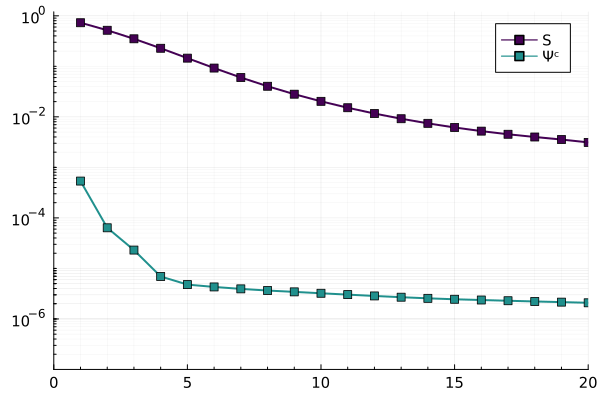

In [126]:
plot(1 .- ES .+ 1e-16, yaxis=:log, linewidth=2, ylim=(1e-7,1.2), marker = :square, c=pal[1], legend = :topright, 
    label = "S", xlim = (0,20), minorgrid = true, legendfontsize=10, tickfontsize = 10) 
plot!(1 .- EΨᶜ .+ 1e-16, linewidth=2, c=pal[3], marker = :square, label = "Ψᶜ" )
#plot!(1 .- EΦᶜ .+ 1e-16, linewidth=2, c=pal[2], marker = :square, label = "Φᶜ")

#plot(ΛΨᶜ ./ ΛΨᶜ[1], yaxis=:log, ylim=(1e-9,1.25), xlim = (1,10), marker=:x, label = "Ψᶜ" )
#plot!(ΛΦᶜ ./ ΛΦᶜ[1], marker=:x, label = "Φᶜ") 
#plot!(ΛS ./ ΛS[1], marker=:x, label = "S")

#savefig("evd.pdf")

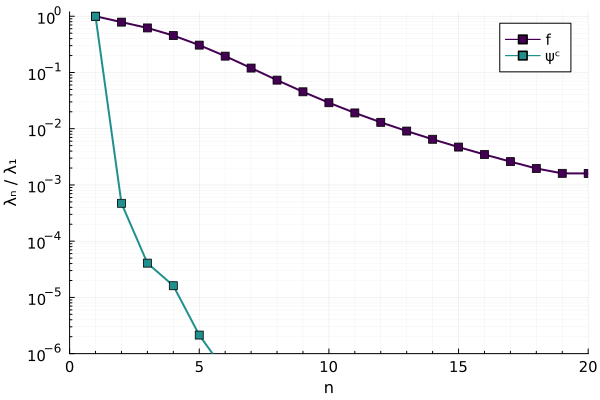

┌ Warning: Invalid negative or zero value -4.7517577315626734e-18 found at series index 234 for log10 based yscale
└ @ Plots /Users/tobias/.julia/packages/Plots/fw4rv/src/utils.jl:86
┌ Warning: Invalid negative or zero value -4.7517577315626734e-18 found at series index 234 for log10 based yscale
└ @ Plots /Users/tobias/.julia/packages/Plots/fw4rv/src/utils.jl:86
┌ Warning: Invalid negative or zero value -4.7517577315626734e-18 found at series index 234 for log10 based yscale
└ @ Plots /Users/tobias/.julia/packages/Plots/fw4rv/src/utils.jl:86


In [130]:
plot(ΛS ./ ΛS[1],  yaxis=:log, linewidth=2, ylim=(1e-6,1.2), marker = :square, xlabel = "n", ylabel = "λₙ / λ₁",
c=pal[1], legend = :topright, label = "f", xlim = (0,20), minorgrid = true, legendfontsize=10, tickfontsize = 10) 
#plot!(ΛΦᶜ ./ ΛΦᶜ[1], linewidth=2, c=pal[2], marker = :square, label = "Φᶜ")
plot!(ΛΨᶜ ./ ΛΨᶜ[1], linewidth=2, c=pal[3], marker = :square, label = "ψᶜ" )
#savefig("ex2evd.pdf")

In [110]:
function _∇ψ♯!(∇ψ♯f, f::AbstractVector{T}, ψᶜ) where T

    n₁, n₂ = size(ci)

    for ij in li

        ∇ψ♯f[ij] = zero(T)
        i,j = Tuple(ci[ij])

        i == 1 ? i₋ = i : i₋ = i-1
        i == n₁ ? i₊ = i : i₊ = i+1

        j == 1 ? j₋ = j : j₋ = j-1
        j == n₂ ? j₊ = j : j₊ = j+1
        
        dy₁ = -1/(2*h₁) * ( ψᶜ[li[i₊,j]] - ψᶜ[li[i₋,j]] )
        dy₂ = -1/(2*h₂) * ( ψᶜ[li[i,j₊]] - ψᶜ[li[i,j₋]] )

        ### find y + ∇ψᶜ(y)

        i₋ = i + Int(floor(dy₁/h₁)) # index left of y + ∇ψᶜ(y)
        j₋ = j + Int(floor(dy₂/h₂)) # indices below y + ∇ψᶜ(y)

        if i₋ < 1 || i₋ > n₁ || j₋ < 1 || j₋ > n₂
            continue  # y + ∇ψᶜ(y) ∉ Ω, assume f(y ∉ Ω) = 0.
            

        end

        dy₁ < 0 ? a = 1 + (dy₁ % h₁) / h₁ : a = (dy₁ % h₁) / h₁ # distance between y₁ + ∂₁ψᶜ(y) and the index to the left
        dy₂ < 0 ? b = 1 + (dy₂ % h₂) / h₂ : b = (dy₂ % h₂) / h₂

        i₋ == n₁ ? i₊ = i₋ : i₊ = i₋+1
        j₋ == n₂ ? j₊ = j₋ : j₊ = j₋+1 # repeat values outside of the domain

        f₋₋ = f[ li[i₋,j₋] ]
        f₊₋ = f[ li[i₊,j₋] ]
        f₋₊ = f[ li[i₋,j₊] ]
        f₊₊ = f[ li[i₊,j₊] ]

        fₓ₁ = (1-a) * f₋₋ + a * f₊₋
        fₓ₂ = (1-a) * f₋₊ + a * f₊₊

        ∇ψ♯f[ij] = (1-b) * fₓ₁ + b * fₓ₂
    end
end

_∇ψ♯! (generic function with 1 method)

In [111]:
nₛ / 5

51.0

In [112]:
m_max = 3   # number of transport modes
n_max = 15  # number of RB elements in reference configuration
Δnₛ = 10 # use every _th snapshot to calculate the average error

nₚ_plot = length(1:Δnₛ:nₛ)

δ_f = zeros(m_max + 1, n_max, nₚ_plot)
Λ_opt = [ zeros(_m, length(ψᶜ)) for _m in 1:m_max ]

for m in 0:m_max

    if m == 0 # POD
        
        T♯S = copy(S)
    
    else

        # transport basis
        Ξ = UΨᶜ[:,1:m]
        # transport coefficients
        λ = [ - h₁ * h₂ * Ξ' * ∇σ∇ * vec(ψᶜ[s]) for s in eachindex(ψᶜ) ]
        for s in eachindex(ψᶜ)
            Λ_opt[m][:,s] .= λ[s]
        end
        
        # approximate mappings from reference configuration 
        ψᶜλ = [ reshape(Ξ * λ[s], N₁, N₂) for s in eachindex(ψᶜ) ];
        # approximate mappingsto reference configuration
        ψλ = [ones(size(α[s])) for s in eachindex(α)]
        for s in eachindex(ψλ)
            WassersteinDictionaries.softmin_separated!(ψλ[s], ψᶜλ[s], log.(β), 1e-8, c, caches.VC[:t1,Float64], caches.MC[:t2,Float64])
        end

        # snapshots in the reference frame
        T♯S = zero(S)
        T♯αᵢ = zeros(N₁*N₂)
        for i in eachindex(α)
            _∇ψ♯!(T♯αᵢ, vec(α[i]), vec(ψᶜλ[i]))
            T♯S[:,i] .= abs.(T♯αᵢ)
        end

    end

    # get the reduced Basis
    evdT♯S = eigen( T♯S' * T♯S * h₁ * h₂, sortby = x -> -abs(x) )
    ΛT♯S = evdT♯S.values
    ET♯S = [ sum(ΛT♯S[1:k]) / sum(ΛT♯S) for k in 1:length(ΛT♯S)]
    UT♯S = T♯S * evdT♯S.vectors * diagm(1 ./ sqrt.(abs.(ΛT♯S)) )

    if m == 0 # POD
        
        T⁻¹♯U = copy(UT♯S)
    
    else

        log_β = log.(β)

        ψᶜᵢ = zero(ψᶜλ[1])
        ψᵢ = zero(ψλ[1])

        # reference basis moved back
        T⁻¹♯U = zeros(N₁*N₂, n_max) 
        uⱼ = zeros(N₁*N₂)
        T⁻¹♯uⱼ = zeros(N₁*N₂)

    end

    _i = 1
    # loop over the test set
    for i_test in 1:Δnₛ:nₛ

        αᵢ = vec(α[i_test])
        
        if m != 0

            ψᶜᵢ .= ψᶜλ[i_test]
            ψᵢ .= 0.0
            WassersteinDictionaries.softmin_separated!(ψᵢ, ψᶜᵢ, log_β, 1e-8, c, caches.VC[:t1,Float64], caches.MC[:t2,Float64]);

            for j in 1:n_max
                uⱼ .= UT♯S[:,j]
                _∇ψ♯!(T⁻¹♯uⱼ, uⱼ, vec(ψᵢ))
                T⁻¹♯U[:,j] .= T⁻¹♯uⱼ
            end

        end

        # loop over RB size
        for n in 1:n_max
            A = T⁻¹♯U[:,1:n]
            a = (A' * A) \ (A' * αᵢ );
            αₐ = A * a
            δ_f[m+1, n, _i] = norm(αₐ - αᵢ) * sqrt(h₁ * h₂)
        end

        _i += 1
    end

end

In [113]:
using Statistics

In [114]:
δ_f_avg = sum(δ_f, dims=3) ./ nₚ_plot;
δ_f_sd = std(δ_f, dims=3)
δ_f_max = maximum(δ_f, dims=3);

In [115]:
pal = cgrad(:viridis, m_max+2, categorical=true)

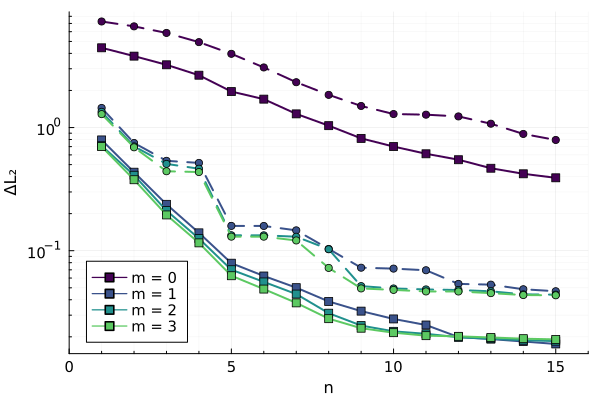

In [116]:
plt = plot( δ_f_avg[1,:], yaxis=:log, xlabel = "n", ylabel = "ΔL₂", c= pal[1], xlim = (0,n_max+1),
#ribbon = δ_f_sd[1,:],fillalpha = 0.2, 
linewidth=2, marker = :square, legend = :bottomleft, label = "m = 0", minorgrid = true, legendfontsize=10, tickfontsize = 10) 
for m in 1:m_max
    plot!( δ_f_avg[m+1,:] , 
    #ribbon = δ_f_sd[m+1,:], fillalpha = 0.2, 
    linewidth=2, marker = :square, label = "m = $(m)",c=pal[m+1])
end
for m in 0:m_max
    plot!( δ_f_max[m+1,:], line=:dash, linewidth=2, marker = :circle, label = false,c=pal[m+1])
end
#plot!( sqrt(h₁ * h₂) * ones(n_max), linewidth=2, c=:grey, label = "h" )
#plot!( ε * ones(n_max), linewidth=2, c=:darkgrey, label = "ε" )
plt
#savefig("ex2l2errors.pdf")

In [134]:
### for plots

m = 1

    if m != 0

        # transport basis
        Ξ = UΨᶜ[:,1:m]
        # transport coefficients
        λ = [ - h₁ * h₂ * Ξ' * ∇σ∇ * vec(ψᶜ[s]) for s in eachindex(ψᶜ) ]
        
        # approximate mappings from reference configuration 
        ψᶜλ = [ reshape(Ξ * λ[s], N₁, N₂) for s in eachindex(ψᶜ) ];
        # approximate mappingsto reference configuration
        ψλ = [ones(size(α[s])) for s in eachindex(α)]
        for s in eachindex(ψλ)
            WassersteinDictionaries.softmin_separated!(ψλ[s], ψᶜλ[s], log.(β), 1e-8, c, caches.VC[:t1,Float64], caches.MC[:t2,Float64])
        end

        # snapshots in the reference frame
        T♯S = zero(S)
        T♯αᵢ = zeros(N₁*N₂)
        for i in eachindex(α)
            _∇ψ♯!(T♯αᵢ, vec(α[i]), vec(ψᶜλ[i]))
            T♯S[:,i] .= abs.(T♯αᵢ)
        end

    end

    # get the reduced Basis
    evdT♯S = eigen( T♯S' * T♯S * h₁ * h₂, sortby = x -> -abs(x) )
    ΛT♯S = evdT♯S.values
    ET♯S = [ sum(ΛT♯S[1:k]) / sum(ΛT♯S) for k in 1:length(ΛT♯S)]
    UT♯S = T♯S * evdT♯S.vectors * diagm(1 ./ sqrt.(abs.(ΛT♯S)) );


In [137]:
    # get the reduced POD Basis
    evdS = eigen( S' * S * h₁ * h₂, sortby = x -> -abs(x) )
    ΛS = evdS.values
    ES = [ sum(ΛS[1:k]) / sum(ΛS) for k in 1:length(ΛS)]
    US = S * evdS.vectors * diagm(1 ./ sqrt.(abs.(ΛS)) );

In [138]:
i_test = rand(1:nₛ)
n = 2
npod = 10

if m == 0 # POD
        
    T⁻¹♯U = copy(UT♯S)

else

    log_β = log.(β)

    ψᶜᵢ = zero(ψᶜλ[1])
    ψᵢ = zero(ψλ[1])

    # reference basis moved back
    T⁻¹♯U = zeros(N₁*N₂, n) 
    uⱼ = zeros(N₁*N₂)
    T⁻¹♯uⱼ = zeros(N₁*N₂)

end

αᵢ = vec(α[i_test])

if m != 0

    ψᶜᵢ .= ψᶜλ[i_test]
    ψᵢ .= 0.0
    WassersteinDictionaries.softmin_separated!(ψᵢ, ψᶜᵢ, log_β, 1e-8, c, caches.VC[:t1,Float64], caches.MC[:t2,Float64]);

    for j in 1:n
        uⱼ .= UT♯S[:,j]
        _∇ψ♯!(T⁻¹♯uⱼ, uⱼ, vec(ψᵢ))
        T⁻¹♯U[:,j] .= T⁻¹♯uⱼ
    end

end

    A = T⁻¹♯U[:,1:n]
    a = (A' * A) \ (A' * αᵢ );
    αₐ = A * a

    Apod = US[:,1:npod]
    apod = (Apod' * Apod) \ (Apod' * αᵢ );
    αpod = Apod * apod


norm(αₐ - αᵢ) * sqrt(h₁ * h₂), norm(αpod - αᵢ) * sqrt(h₁ * h₂)

(0.7632548734456999, 0.8262737996947807)

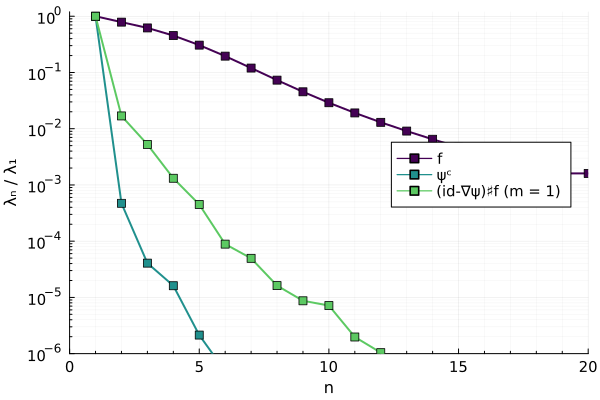

┌ Warning: Invalid negative or zero value -4.7517577315626734e-18 found at series index 234 for log10 based yscale
└ @ Plots /Users/tobias/.julia/packages/Plots/fw4rv/src/utils.jl:86
┌ Warning: Invalid negative or zero value -4.7517577315626734e-18 found at series index 234 for log10 based yscale
└ @ Plots /Users/tobias/.julia/packages/Plots/fw4rv/src/utils.jl:86
┌ Warning: Invalid negative or zero value -4.7517577315626734e-18 found at series index 234 for log10 based yscale
└ @ Plots /Users/tobias/.julia/packages/Plots/fw4rv/src/utils.jl:86


In [139]:
plot(ΛS ./ ΛS[1],  yaxis=:log, linewidth=2, ylim=(1e-6,1.2), marker = :square,  xlabel = "n", ylabel = "λₙ / λ₁",
c=pal[1], legend = :right, label = "f", xlim = (0,20), minorgrid = true, legendfontsize=10, tickfontsize = 10) 
plot!(ΛΨᶜ ./ ΛΨᶜ[1], linewidth=2, c=pal[3], marker = :square, label = "ψᶜ" )
plot!(ΛT♯S ./ ΛT♯S[1], linewidth=2, c=pal[4], marker = :square, label = "(id-∇ψ)♯f (m = $m)")
#savefig("ex2evd2.pdf")

In [149]:
__i = nₛ # rand(1:nₛ)

255

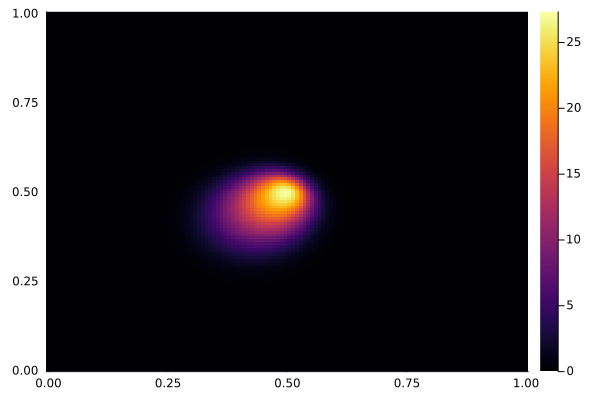

In [150]:
heatmap(x₁, x₂, reshape(T♯S[:,__i], N₁, N₂))

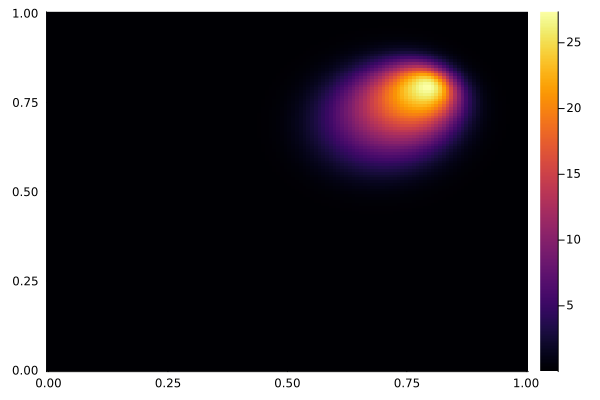

In [151]:
heatmap(x₁, x₂, reshape(S[:,__i], N₁, N₂))

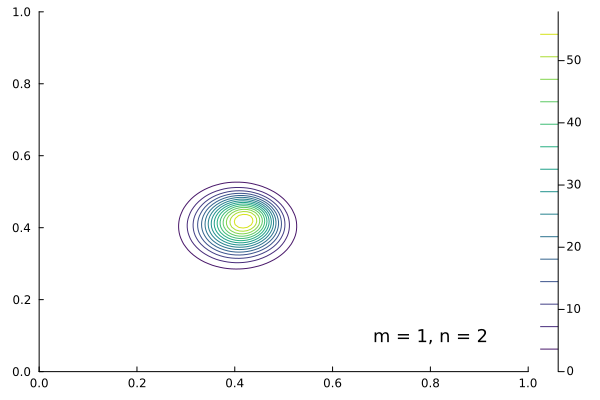

In [122]:
contour(x₁, x₂, αₐ, c = :viridis, grid = false )
annotate!(0.8, 0.1, ("m = $m, n = $n", 12) )

#savefig("ex2recon.pdf")

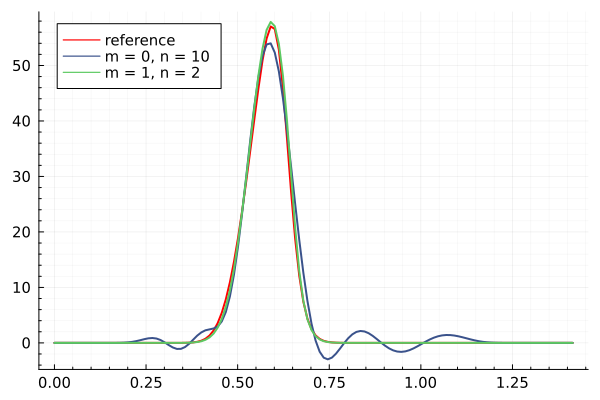

In [124]:
function diagslice(f)
    f_d = zeros(N₁)
    for i in 1:N₁
        ij = li[ci[i,i]]
        f_d[i] = f[ij]
    end
    return f_d
end

plot(x₁ .* sqrt(2), diagslice(αᵢ), label = "reference", linewidth=2, minorgrid = true, legend=:topleft,
    c=:red, legendfontsize=10, tickfontsize = 10)
plot!(x₁ .* sqrt(2), diagslice(αpod), label = "m = 0, n = $(npod)", linewidth=2, c=pal[2])
plot!(x₁ .* sqrt(2), diagslice(αₐ), label = "m = $m, n = $n", linewidth=2, c=pal[4])

#savefig("ex2diagslice.pdf")

diagslice (generic function with 1 method)

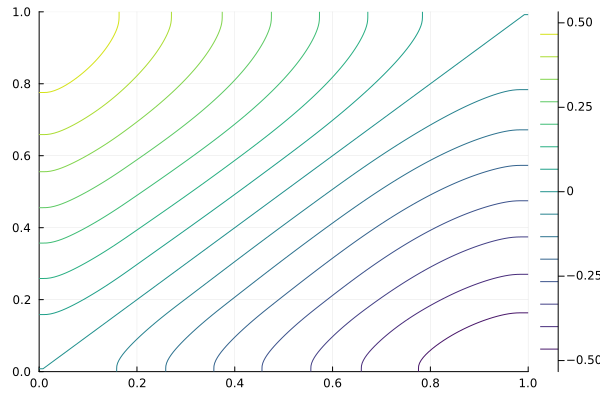

In [139]:
contour(x₁, x₂, UΨᶜ[:,1], c=:viridis)
#savefig("ex2xi4.pdf")
#contour!(x₁, x₂, 0.0001*β)


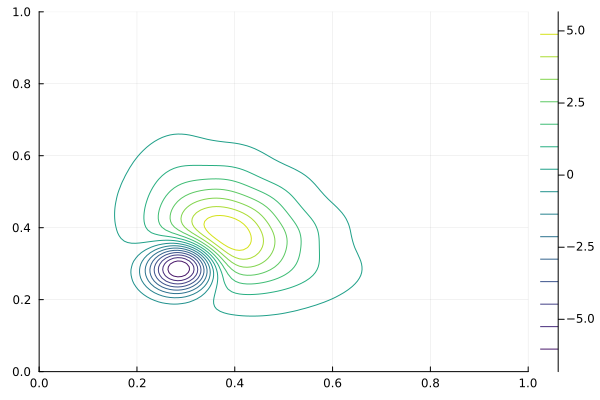

In [140]:
contour(x₁, x₂, UT♯S[:,2], c = :viridis)
#savefig("ex2mode4.pdf")

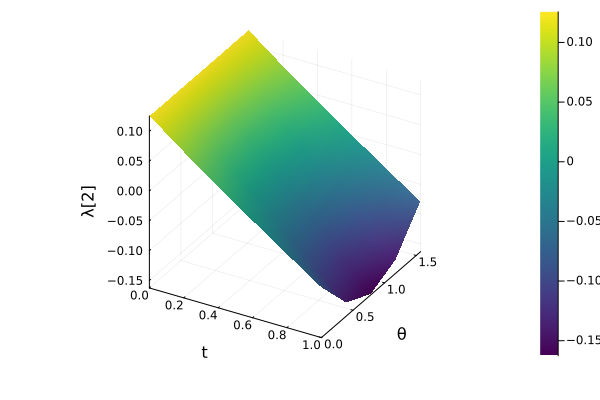

In [143]:
nₜ_plot = div(nₛ,length(θ))
_i = 2
surface(range(0,1,length=nₜ_plot), θ , Λ_opt[3][_i,:], c=:viridis, ylabel = "θ", xlabel = "t", zlabel = "λ[$_i]")
#savefig("ex2lambdamap1.pdf")

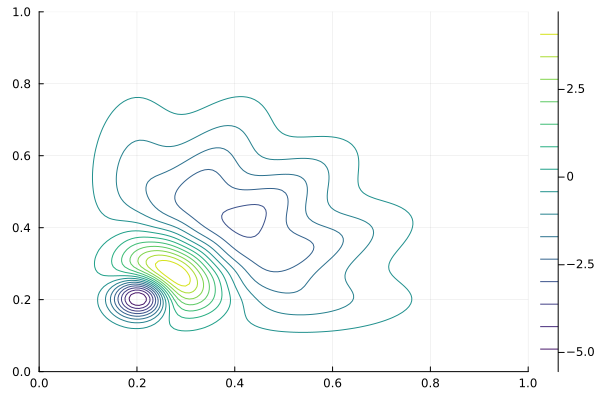

In [144]:
contour(x₁, x₂, US[:,4], c = :viridis)
#savefig("ex2fmode4.pdf")

In [475]:
size(Λ_opt[3][1,2:end]), nₜ_plot * length(μ), (nₛ)/3, nₜ_plot

((218,), 215, 73.0, 43)

In [455]:
size(Λ_opt[3]), nₛ

((3, 219), 219)

In [523]:
#λ = [ Ξ' * ∇σ∇ * vec(φᶜ[s]) for s in eachindex(φᶜ) ]
λ = [ Ξ' * ∇σ∇ * vec(ψᶜ[s]) for s in eachindex(ψᶜ) ];

In [524]:
#plot( collect( dot(Ξ * λ[i] - vec(ψᶜ[i]), ∇σ∇,  Ξ * λ[i] - vec(ψᶜ[i])) for i in eachindex(ψᶜ) ), yaxis=:log )

In [525]:
#plt = plot( collect( λ[i][1] for i in eachindex(ψᶜ) ) )
#for j in 2:length(λ[1])
#    plot!( collect( λ[i][j] for i in eachindex(ψᶜ) ) )
#end
#plt

In [496]:
nₜ_plot = div(nₚ-1,length(θ))

10

In [526]:
#contourf(range(0,1,length=nₜ_plot), θ , collect( λ[i][1] for i in 2:nₚ ), 
#c=:viridis, ylabel = "θ", xlabel = "t")
#savefig("ex2lambdamap4.pdf")

In [498]:
ψᶜλ = [ reshape(Ξ * λ[s], n₁, n₂) for s in eachindex(ψᶜ) ];
#plot( collect( dot(vec(ψᶜ[s] - ψᶜλ[s]), ∇σ∇, vec(ψᶜ[s] - ψᶜλ[s]) ) for s in eachindex(φᶜ) ), yaxis=:log );

In [499]:
# move everything to reference configuration
ψλ = [ones(size(α[s])) for s in eachindex(α)]

for s in eachindex(ψλ)

    WassersteinDictionaries.softmin_separated!(ψλ[s], ψᶜλ[s], log.(β), 1e-6, 0.5*c, caches.VC[:t1,Float64], caches.MC[:t2,Float64])

end

#=
for s in eachindex(ψλ)
    caches.MC[:b,Float64] .= exp.( -ψᶜλ[s] / ε ) .* β
    WassersteinDictionaries.apply_K_sep!(caches.MC[:a_α,Float64], caches.MC[:b,Float64], k, caches.MC[:t1,Float64])
    ψλ[s] .= ε .* log.( caches.MC[:a_α,Float64] )
end
=#

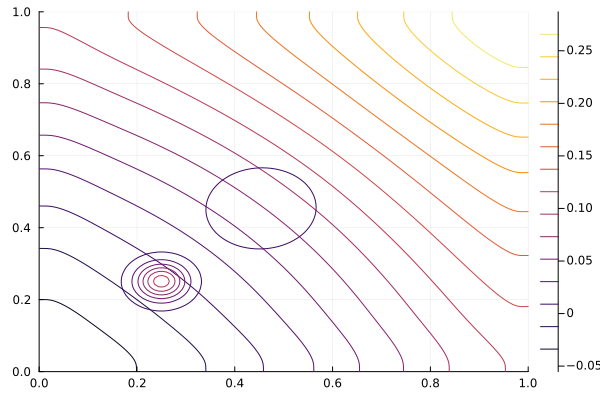

In [500]:
contour(x₁, x₂, ψᶜλ[1] )
contour!(x₁, x₂, 1e-3*α[1])
contour!(x₁, x₂, 1e-3*β)

In [501]:
function _∇ψ♯!(∇ψ♯f, f::AbstractVector{T}, ψᶜ) where T

    n₁, n₂ = size(ci)

    for ij in li

        ∇ψ♯f[ij] = zero(T)
        i,j = Tuple(ci[ij])

        i == 1 ? i₋ = i : i₋ = i-1
        i == n₁ ? i₊ = i : i₊ = i+1

        j == 1 ? j₋ = j : j₋ = j-1
        j == n₂ ? j₊ = j : j₊ = j+1
        
        dy₁ = -1/(2*h₁) * ( ψᶜ[li[i₊,j]] - ψᶜ[li[i₋,j]] )
        dy₂ = -1/(2*h₂) * ( ψᶜ[li[i,j₊]] - ψᶜ[li[i,j₋]] )

        ### find y + ∇ψᶜ(y)

        i₋ = i + Int(floor(dy₁/h₁)) # index left of y + ∇ψᶜ(y)
        j₋ = j + Int(floor(dy₂/h₂)) # indices below y + ∇ψᶜ(y)

        if i₋ < 1 || i₋ > n₁ || j₋ < 1 || j₋ > n₂ # y + ∇ψᶜ(y) ∉ Ω, assume f(y ∉ Ω) = 0.
            continue
        end

        dy₁ < 0 ? a = 1 + (dy₁ % h₁) / h₁ : a = (dy₁ % h₁) / h₁ # distance between y₁ + ∂₁ψᶜ(y) and the index to the left
        dy₂ < 0 ? b = 1 + (dy₂ % h₂) / h₂ : b = (dy₂ % h₂) / h₂

        i₋ == n₁ ? i₊ = i₋ : i₊ = i₋+1
        j₋ == n₂ ? j₊ = j₋ : j₊ = j₋+1 # repeat values outside of the domain

        f₋₋ = f[ li[i₋,j₋] ]
        f₊₋ = f[ li[i₊,j₋] ]
        f₋₊ = f[ li[i₋,j₊] ]
        f₊₊ = f[ li[i₊,j₊] ]

        fₓ₁ = (1-a) * f₋₋ + a * f₊₋
        fₓ₂ = (1-a) * f₋₊ + a * f₊₊

        ∇ψ♯f[ij] = (1-b) * fₓ₁ + b * fₓ₂
    end
end

_∇ψ♯! (generic function with 1 method)

In [543]:
T♯α = [zeros(size(α[s])) for s in eachindex(α)] 
T♯♯α = [zeros(size(α[s])) for s in eachindex(α)] 
αᵢ = zeros(n₁*n₂)
ψᶜᵢ = zeros(n₁*n₂)
ψᵢ = zeros(n₁*n₂)
T♯αᵢ = zeros(n₁*n₂)
T♯♯αᵢ = zeros(n₁*n₂)
T♯S = zero(S)

for i in eachindex(T♯α)

    αᵢ .= vec(α[i])
    ψᶜᵢ .= vec(ψᶜλ[i])
    _∇ψ♯!(T♯αᵢ, vec(α[i]), vec(ψᶜλ[i]))
    T♯S[:,i] .= abs.(T♯αᵢ)
    #T♯α[i] .= reshape(T♯αᵢ, n₁, n₂)

    #ψᵢ .= vec(ψλ[i])
    #_∇ψ♯!(T♯♯αᵢ, T♯αᵢ, ψᵢ)

    #T♯♯α[i] .= reshape(T♯♯αᵢ, n₁, n₂)
    
end

In [532]:
T♯S = zero(S)
for i in eachindex(α)
    T♯S[:,i] .= abs.(vec(T♯α[i]))
end

In [544]:
evdT♯S = eigen( T♯S' * T♯S * h₁ * h₂, sortby = x -> -abs(x) )
ΛT♯S = evdT♯S.values
ET♯S = [ sum(ΛT♯S[1:k]) / sum(ΛT♯S) for k in 1:length(ΛT♯S)]
UT♯S = T♯S * evdT♯S.vectors * diagm(1 ./ sqrt.(abs.(ΛT♯S)) );

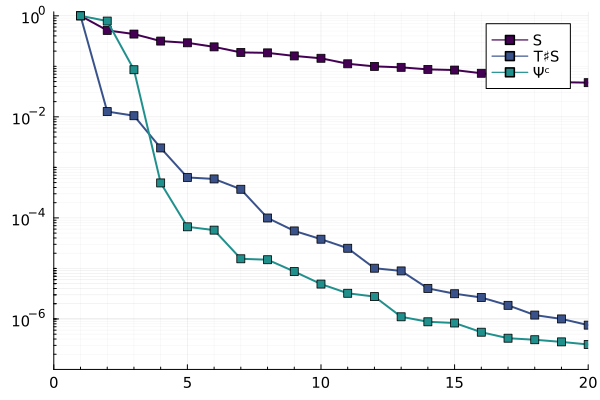

In [545]:
plot(ΛS ./ ΛS[1],  yaxis=:log, linewidth=2, ylim=(1e-7,1.2), marker = :square, 
c=pal[1], legend = :topright, label = "S", xlim = (0,20), minorgrid = true, legendfontsize=10, tickfontsize = 10) 
plot!(ΛT♯S ./ ΛT♯S[1], linewidth=2, c=pal[2], marker = :square, label = "T♯S")
plot!(ΛΨᶜ ./ ΛΨᶜ[1], linewidth=2, c=pal[3], marker = :square, label = "Ψᶜ" )

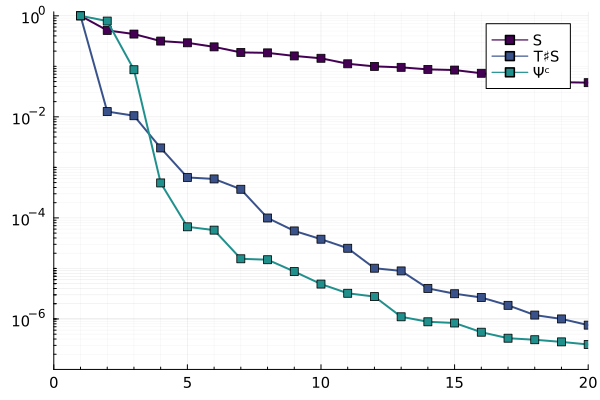

In [505]:
plot(ΛS ./ ΛS[1],  yaxis=:log, linewidth=2, ylim=(1e-7,1.2), marker = :square, 
c=pal[1], legend = :topright, label = "S", xlim = (0,20), minorgrid = true, legendfontsize=10, tickfontsize = 10) 
plot!(ΛT♯S ./ ΛT♯S[1], linewidth=2, c=pal[2], marker = :square, label = "T♯S")
plot!(ΛΨᶜ ./ ΛΨᶜ[1], linewidth=2, c=pal[3], marker = :square, label = "Ψᶜ" )

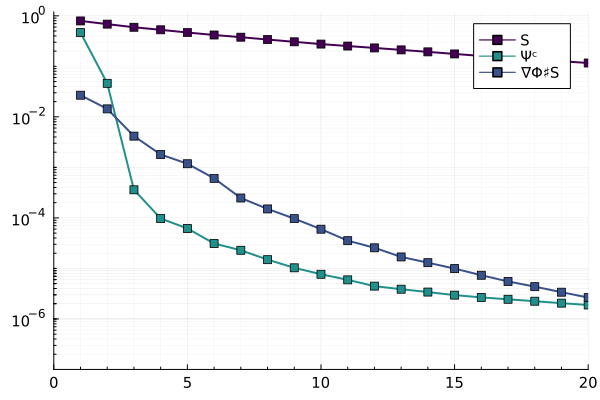

In [506]:
plot(1 .- ES .+ 1e-12, yaxis=:log, linewidth=2, ylim=(1e-7,1.2), marker = :square, 
c=pal[1], legend = :topright, label = "S", xlim = (0,20), minorgrid = true, legendfontsize=10, tickfontsize = 10) 
plot!(1 .- EΨᶜ .+ 1e-12, linewidth=2, c=pal[3], marker = :square, label = "Ψᶜ" )
plot!(1 .- ET♯S .+ 1e-12, linewidth=2, c=pal[2], marker = :square,  label = "∇Φ♯S")

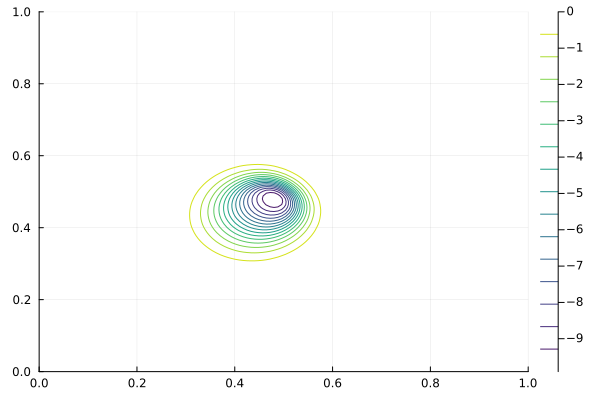

In [507]:
contour(x₁, x₂, UT♯S[:,1], c = :viridis)
#savefig("mode4.pdf")

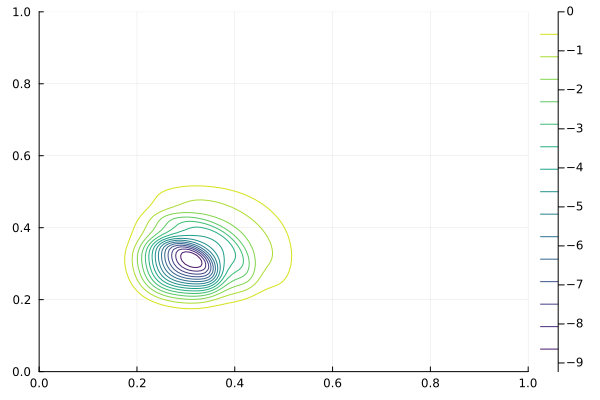

In [508]:
contour(x₁, x₂, US[:,1], c = :viridis)
#savefig("mode4.pdf")

In [510]:
x_vec = zeros(length(li),2)
for ij in li
    i,j = Tuple(ci[ij])
    x_vec[ij,1] = x₁[i]
    x_vec[ij,2] = x₂[j]
end

function quad_interp_1d(x₀, f, x)
    @assert length(f) == length(x) == 3
    # value of quad. interpolant of f (1D) at x₀
    return ( (x₀ - x[2])/(x[1]-x[2]) * (x₀ - x[3])/(x[1]-x[3]) * f[1]
           + (x₀ - x[1])/(x[2]-x[1]) * (x₀ - x[3])/(x[2]-x[3]) * f[2]
           + (x₀ - x[1])/(x[3]-x[1]) * (x₀ - x[2])/(x[3]-x[2]) * f[3] )
end

function quad_interp_2d(x₀, f, x₁, x₂)
    @assert length(x₀) == 2
    @assert length(x₁) == length(x₂) == 3
    @assert size(f) == (3,3)
    # row - wise interpolation
    _f = [ quad_interp_1d(x₀[1], f[:,i], x₁) for i in 1:3 ]
    # column - wise interpolation
    return quad_interp_1d(x₀[2], _f, x₂)
end

quad_interp_2d (generic function with 1 method)

In [511]:
nₚ

101

In [512]:
length(1:5:nₚ)

21

In [513]:
m = 20

nₚ_plot = length(1:5:nₚ)

δ_fₐ = zeros(m, nₚ_plot)
δ_f_pod = zeros(m, nₚ_plot)

log_β = log.(β)

ψᶜᵢ = zero(ψᶜλ[1])
ψᵢ = zero(ψλ[1])

T⁻¹♯U = zeros(n₁*n₂, m)

uⱼ = zeros(n₁*n₂)
T⁻¹♯uⱼ = zeros(n₁*n₂)

_i = 1

for i_test in 1:5:nₚ

    αᵢ .= vec(α[i_test])

    ψᶜᵢ .= ψᶜλ[i_test]
    ψᵢ .= 0.0
    WassersteinDictionaries.softmin_separated!(ψᵢ, ψᶜᵢ, log_β, 1e-6, 0.5*c, caches.VC[:t1,Float64], caches.MC[:t2,Float64]);

    #@time _find_ψᶜ₂!(ψᵢ, ψᶜᵢ, x_vec, x_vec, ci, li);

    for j in 1:m

        uⱼ .= UT♯S[:,j]
        
        _∇ψ♯!(T⁻¹♯uⱼ, uⱼ, vec(ψᵢ))

        T⁻¹♯U[:,j] .= T⁻¹♯uⱼ
    end


    for _m in 1:m
        A = T⁻¹♯U[:,1:_m];
        #A = (vec(β) * ones(_m)') .* T⁻¹♯U[:,1:_m];
        a = (A' * A) \ (A' * αᵢ );
        αₐ = A * a
        δ_fₐ[_m, _i] = norm(αₐ - αᵢ) * sqrt(h₁ * h₂) #/ norm(αᵢ) # * sqrt(h₁ * h₂)

        A_pod = US[:,1:_m]
        a = (A_pod' * A_pod) \ (A_pod' * αᵢ )
        α_pod = A_pod * a
        δ_f_pod[_m, _i] = norm(α_pod - αᵢ)  * sqrt(h₁ * h₂) # / norm(αᵢ) 
    end

    _i += 1
end


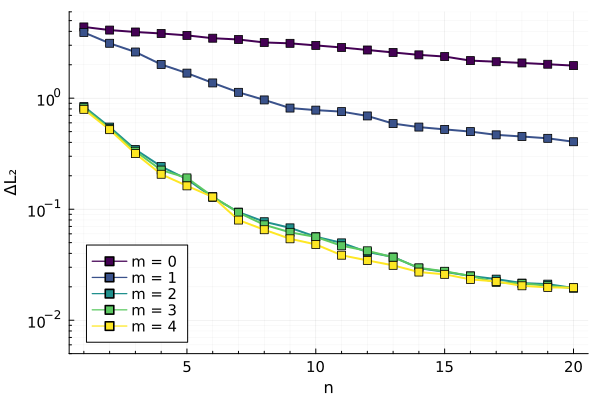

In [522]:
plot( sum(δ_f_pod,dims=2) ./ nₚ_plot , ylim = (5 * 1e-3, 6), yaxis=:log, xlabel = "n", ylabel = "ΔL₂",
linewidth=2, marker = :square, c=pal[1], legend = :bottomleft, label = "m = 0", minorgrid = true, legendfontsize=10, tickfontsize = 10) 

plot!( sum(δ_fₐ1,dims=2) ./ nₚ_plot , linewidth=2, marker = :square, c=pal[2], label = "m = 1")
plot!( sum(δ_fₐ2,dims=2) ./ nₚ_plot , linewidth=2, marker = :square, c=pal[3], label = "m = 2")
plot!( sum(δ_fₐ3,dims=2) ./ nₚ_plot , linewidth=2, marker = :square, c=pal[4], label = "m = 3")

plot!( sum(δ_fₐ,dims=2) ./ nₚ_plot , linewidth=2, marker = :square, c=pal[5], label = "m = $n_test")

#plot!( sqrt(h₁ * h₂) * ones(m), linewidth=2, c=:grey, label = "h" )

In [484]:
i_test = 50
m_test = 3
m_pod = m_test + n_test

αᵢ .= vec(α[i_test])

ψᶜᵢ.= ψᶜλ[i_test]
ψᵢ .= 0.0
WassersteinDictionaries.softmin_separated!(ψᵢ, ψᶜᵢ, log_β, 1e-6, 0.5*c, caches.VC[:t1,Float64], caches.MC[:t2,Float64]);


for j in 1:m
    uⱼ .= UT♯S[:,j]
    _∇ψ♯!(T⁻¹♯uⱼ, uⱼ, vec(ψᵢ))
    T⁻¹♯U[:,j] .= T⁻¹♯uⱼ
end


A = T⁻¹♯U[:,1:m_test];
a = (A' * A) \ (A' * αᵢ );
αₐ = A * a
A_pod = US[:,1:m_pod]
a = (A_pod' * A_pod) \ (A_pod' * αᵢ )
α_pod = A_pod * a;

In [485]:
m_test, n_test

(3, 1)

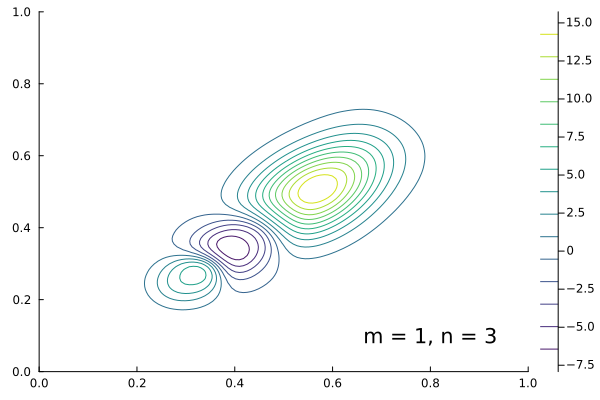

In [486]:
contour(x₁, x₂, αₐ, c = :viridis, grid = false )
annotate!(0.8, 0.1, ("m = $n_test, n = $m_test", 14) )
#contour!(x₁, x₂, α_pod, c = :viridis )

#savefig("ex2_recon.pdf")

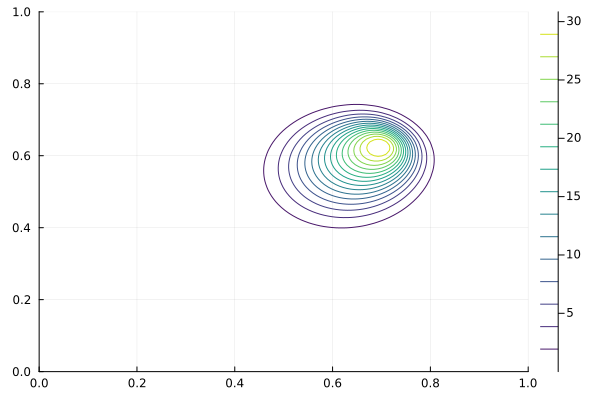

In [487]:
contour(x₁, x₂, αᵢ, c = :viridis )

In [488]:
function diagslice(f)
    f_d = zeros(n₁)
    for i in 1:n₁
        ij = li[ci[i,i]]
        f_d[i] = f[ij]
    end
    return f_d
end

diagslice (generic function with 1 method)

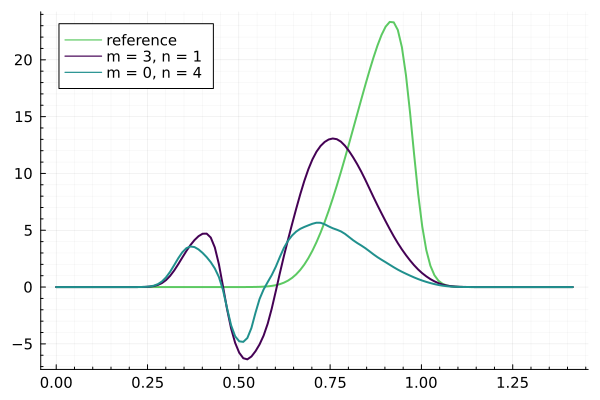

In [489]:
plot(x₁ .* sqrt(2), diagslice(αᵢ), label = "reference", legend = :topleft, linewidth=2, minorgrid = true, 
    c=pal[4], legendfontsize=10, tickfontsize = 10) 
#plot!(x .* sqrt(2), diagslice(fλ), label = "fλ", linewidth=2)
plot!(x₁ .* sqrt(2), diagslice(αₐ), label = "m = $m_test, n = $n_test", linewidth=2, c=pal[1])
plot!(x₁ .* sqrt(2), diagslice(α_pod), label = "m = 0, n = $m_pod", linewidth=2, c=pal[3])

#savefig("ex2diagslice.pdf")

In [107]:
function optimcallback(x, loss)

    push!(y_trace, loss(x[end].metadata["x"]) )
    push!(x_trace, softmax(x[end].metadata["x"]))

    if y_trace[end] < 1e-9
        return true
    else
        return false
    end
end

optimcallback (generic function with 1 method)

In [325]:
S

3

In [326]:
ΔW = zeros(Sₜ)
λ = [zeros(S) for _ in 1:Sₜ]

results = []

for s in 1:Sₜ

    q = p[s]

    a₀ .= 1; b₀ .= 1
    d₀₁ .= 1; d₀₂ .= 1

    for s_ in 1:S
        b_₀[s_] .= 1
    end
    d₀ .= 1

    function w2_loss_separated(w::Vector{T}) where T
        μ_λ = sinkhorn_barycenter_separated(softmax(w), α, b_₀, d₀, k, SPB, caches)
        return abs( sinkhorn_dvg_separated(μ_λ, q, a₀, b₀, d₀₁, d₀₂, k, SP, caches) ) #+ sqeuclidean(μ_λ,q)/norm(q)^2
    end

    SP.L = 32
    SPB.L = 48

    brk = false
    for s_α in eachindex(α_indices)
        if s == α_indices[s_α]
            λ[s][s_α] = 1
            ΔW[s] = 0.0
            brk = true
        end
    end

    if brk
        continue
    end

    result = optimize(  w2_loss_separated,
                        zeros(S),                     
                        LBFGS(  #linesearch = LineSearches.BackTracking( c_1=1e-6, iterations = 100),
                                #alphaguess = LineSearches.InitialStatic()
                            ),
                        Optim.Options(  callback = x -> optimcallback(x, w2_loss_separated),
                                        iterations = 48,
                                        allow_f_increases = true,
                                        store_trace = true,
                                        extended_trace = true,
                                        g_tol = 1e-9,
                                        f_tol = 1e-6),
                        autodiff=:forward   )

    push!(results, result)

    wₒₚₜ = Optim.minimizer(result)
    λ[s] = softmax(wₒₚₜ)
    ΔW[s] = Optim.minimum(result)
end

In [327]:
results[1]

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     3.358471e-08

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 3.90e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.77e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.90e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.95e-02 ≰ 1.0e-06
    |g(x)|                 = 4.31e-06 ≰ 1.0e-09

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    48
    f(x) calls:    132
    ∇f(x) calls:   132


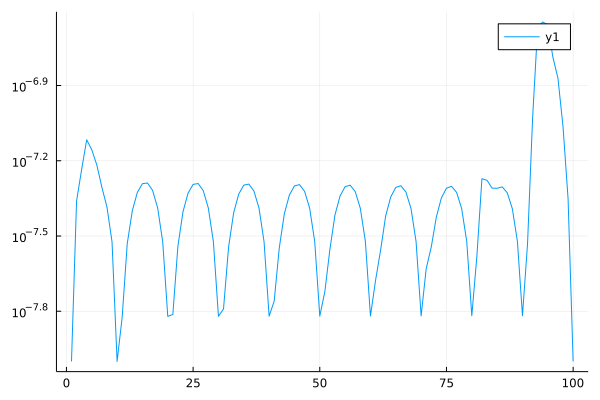

In [328]:
plot(ΔW .+ 1e-8, yaxis=:log)

In [329]:
argmax(ΔW)

94

In [330]:
λ

100-element Vector{Vector{Float64}}:
 [1.0, 0.0, 0.0]
 [0.8888477640809859, 0.010888907717614851, 0.10026332820139922]
 [0.777810176405019, 0.01289438087758309, 0.2092954427173979]
 [0.6666595973033211, 0.01674218182978941, 0.3165982208668895]
 [0.5555552069897345, 0.01365732676620308, 0.43078746624406244]
 [0.4444749772584032, 0.009599498680386025, 0.5459255240612108]
 [0.3333157723607668, 0.003913883467605425, 0.6627703441716278]
 [0.2222144183966196, 0.001912121870224285, 0.775873459733156]
 [0.11111113175527229, 0.00029032205356631103, 0.8885985461911614]
 [0.0, 0.0, 1.0]
 ⋮
 [0.8889622323387915, 0.10790681552367484, 0.0031309521375337147]
 [0.7776654306317432, 0.20999606049216912, 0.012338508876087702]
 [0.6666224574766461, 0.3239744090968847, 0.009403133426469337]
 [0.5555417872233069, 0.4373256131533512, 0.00713259962334189]
 [0.4444722391431384, 0.554350012823254, 0.0011777480336075984]
 [0.3333243921906985, 0.6653569004177102, 0.0013187073915914196]
 [0.22221649635975818, 0.77

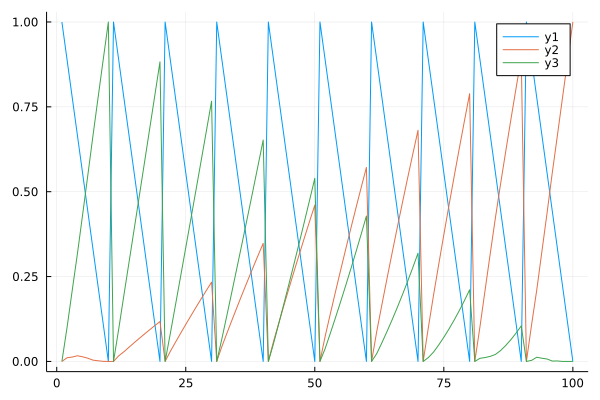

In [331]:
plt = plot( [λ[s][1] for s in eachindex(λ)] )
for i in 2:S
    plot!( [λ[s][i] for s in eachindex(λ)] )
end
plt

In [332]:
pᵣ = copy(p)
SPB.L = 64
for s in 1:Sₜ
    pᵣ[s] = sinkhorn_barycenter_separated(λ[s], α, b_₀, d₀, k, SPB, caches)
end

In [333]:
ΔL₁ = [ norm(p[s]-pᵣ[s],1) for s in 1:Sₜ ];

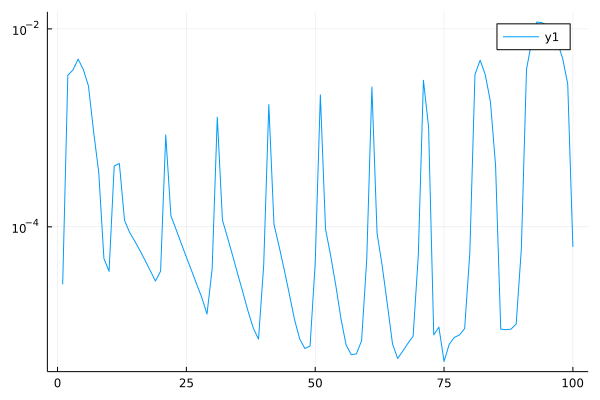

In [334]:
plot(ΔL₁, yaxis=:log)

In [357]:
sum(ΔL₁)./Sₜ, sum(ΔW)./Sₜ

(0.0011906667291873005, 3.646740579072315e-8)

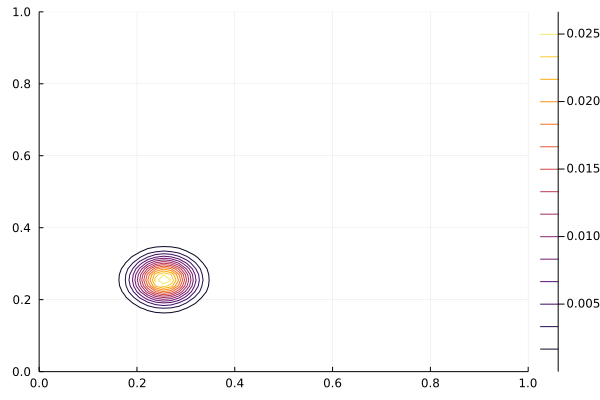

In [336]:
s_ = 1
contour(x₁, x₂, pᵣ[s_])

In [337]:
push!(ΔL1_trace, sum(ΔL₁)./Sₜ)

2-element Vector{Any}:
 0.004064602514600633
 0.0011906667291873005

In [303]:
#ΔL1_trace = []

In [304]:
#pop!(ΔL1_trace)

# SVD

In [338]:
Snap = zeros(n^2,Sₜ)

for s in 1:Sₜ
    Snap[:,s] .= reshape(p[s],n^2)
end

F = svd(Snap);

In [339]:
fieldnames(typeof(F))

(:U, :S, :Vt)

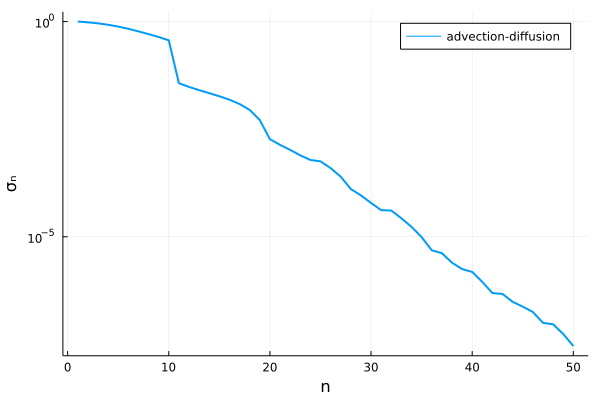

In [340]:
plot(F.S[1:50]./F.S[1], yaxis = :log, linewidth=2, xlab="n", ylab="σₙ", label="advection-diffusion")
#plot!(S_diff[1:50]./S_diff[1], yaxis = :log, linewidth=2, xlab="n", ylab="σₙ", label="pure diffusion")
#savefig("sv_advection_diffusion.png")

In [341]:
modes = [ reshape(F.U[:,s], (n,n)) for s in 1:Sₜ  ];

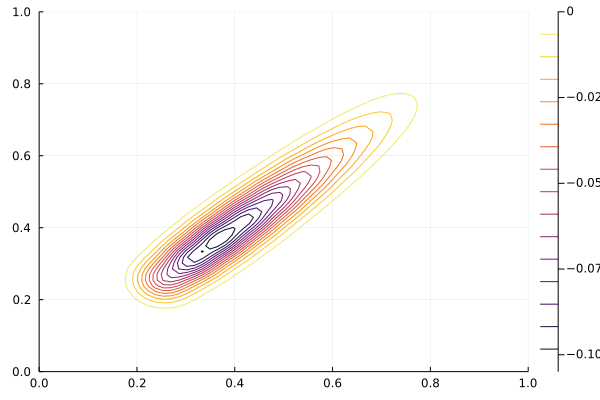

In [342]:
contour(x₁, x₁, modes[1])

In [351]:
ΔL1_trace_svd = []
for ns in 2:30
    pₛᵥ = [ reshape( F.U[:,1:ns] * F.U[:,1:ns]' * Snap[:,s], (n,n)) for s in 1:Sₜ ]
    ΔL₁_svd = [ norm(p[s]-pₛᵥ[s],1) for s in 1:Sₜ ]
    push!(ΔL1_trace_svd, sum(ΔL₁_svd)./Sₜ)
end


In [361]:
ΔL1_trace_svd[19]

0.001191365457427202

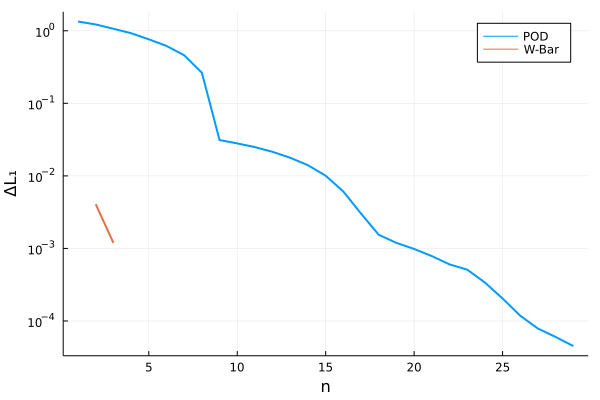

attempt to save state beyond implementation limit


In [359]:
plot(ΔL1_trace_svd, yaxis = :log, linewidth=2, xlab="n", ylab="ΔL₁", label="POD")
plot!(2:3, ΔL1_trace, yaxis = :log, linewidth=2, label="W-Bar")

In [356]:
ΔL1_trace_svd[end-10:end]

11-element Vector{Any}:
 0.001191365457427202
 0.0009821008803159049
 0.0007834483861339444
 0.0006022477521685092
 0.0005091804356072532
 0.0003385212298353087
 0.00020378203789357487
 0.00011796071614526522
 7.85258732405193e-5
 6.006239893791138e-5
 4.5066312971454076e-5

In [346]:
#ΔL1_trace_svd = []

In [347]:
ns = 10
pₛᵥ = [ reshape( F.U[:,1:ns] * F.U[:,1:ns]' * Snap[:,s], (n,n)) for s in 1:Sₜ ];

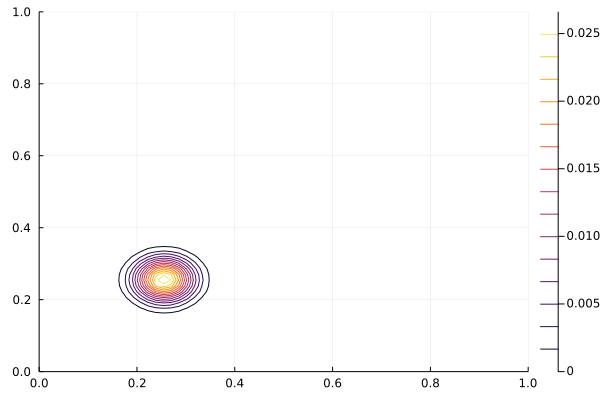

In [348]:
s_ = 11
contour(x₁, x₂, pₛᵥ[s_])